# Load your data

Before finetuning a pretrained model of the experiments we provide in our repository (or precomputed and provided [here](https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq)), first load your custom 100 Hz sampled 12-lead ECG signal data `X` of shape `[N,L,12]` in Millivolts (mV) and multi-hot encoded labels `y` of shape `[N,C]` as numpy arrays, where `C` is the number of classes and `N` the number of total samples in this dataset. Although PTB-XL comes with fixed `L=1000` (i,e. 10 seconds), it is not required to be fixed, **BUT** the shortest sample must be longer than `input_size` of the specific model (e.g. 2.5 seconds for our fastai-models).

For proper tinetuning split your data into four numpy arrays: `X_train`,`y_train`,`X_val` and `y_val`

### Example: finetune model trained on all (71) on superdiagnostic (5)
Below we provide an example for loading [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/) aggregated at the `superdiagnostic` level, where we use the provided folds for train-validation-split:

In [3]:
!pip install wget wfdb tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import wget
import numpy as np
import os
import zipfile
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow_addons as tfa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [6]:
!wget https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip

os.mkdir("./data/")


with zipfile.ZipFile("./ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/")

--2023-03-28 06:32:23--  https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1842722380 (1.7G) [application/zip]
Saving to: ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip’

ptb-xl-a-large-publ 100%[===================>]   1.72G   704KB/s    in 39m 59s 

2023-03-28 07:12:22 (750 KB/s) - ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip’ saved [1842722380/1842722380]



In [7]:
!pip install GitPython
from git import Repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00


In [8]:
HTTPS_REMOTE_URL = 'https://github.com/Bsingstad/ecg_ptbxl_benchmarking.git'
DEST_NAME = 'github_repo'

In [9]:
Repo.clone_from(HTTPS_REMOTE_URL, DEST_NAME)

<git.repo.base.Repo '/content/github_repo/.git'>

In [10]:
from github_repo.code import *
%matplotlib inline
%load_ext autoreload

In [11]:
from github_repo.code.utils import utils

sampling_frequency=100
datafolder='./data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
task= 'superdiagnostic' # 'all' , 'diagnostic' , 'subdiagnostic', 'superdiagnostic', 'form', 'rhythm'
outputfolder='./github_repo/output/'

# Load PTB-XL data
data, raw_labels = utils.load_dataset(datafolder, sampling_frequency)
# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
# Select relevant data and convert to one-hot
#data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

# 1-9 for training 
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

num_classes = y_train.shape[1]    # <=== number of classes in the finetuning dataset
input_shape = [1000,12] # <=== shape of samples, [None, 12] in case of different lengths

X_train.shape, y_train.shape, X_val.shape, y_val.shape

100%|██████████| 21837/21837 [01:05<00:00, 334.36it/s]


((19267, 1000, 12), (19267, 5), (2163, 1000, 12), (2163, 5))

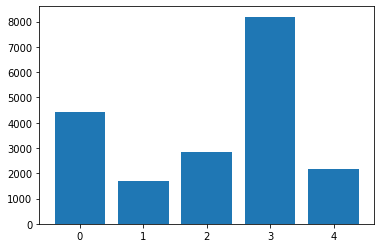

In [12]:
import matplotlib.pyplot as plt

plt.bar(np.unique(y_train.argmax(axis=1),return_counts=True)[0],np.unique(y_train.argmax(axis=1),return_counts=True)[1])
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

_, X_grid, _, y_grid= train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [14]:
X_grid.shape

(1927, 1000, 12)

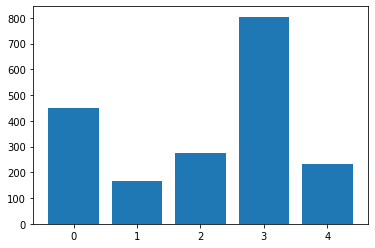

In [15]:
plt.bar(np.unique(y_grid.argmax(axis=1),return_counts=True)[0],np.unique(y_grid.argmax(axis=1),return_counts=True)[1])
plt.show()

# Train or download models
There are two possibilities:
   1. Run the experiments as described in README. Afterwards you find trained in models in `output/expX/models/`
   2. Download the precomputed `output`-folder with all experiments and models from [here]((https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq))

# Load pretrained model

For loading a pretrained model:
   1. specify `modelname` which can be seen in `code/configs/` (e.g. `modelname='fastai_xresnet1d101'`)
   2. provide `experiment` to build the path `pretrainedfolder` (here: `exp0` refers to the experiment with `all` 71 SCP-statements)
   
This returns the pretrained model where the classification is replaced by a random initialized head with the same number of outputs as the number of classes.

In [16]:
from github_repo.code.models.base_model import ClassificationModel
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

        
class inception_time_model(ClassificationModel):
    def __init__(self, name, n_classes,  sampling_frequency, outputfolder, input_shape, epoch=30, batch_size=32, lr_init = 0.001, lr_red="yes", model_depth=6, loss="bce", kernel_size=40, bottleneck_size=32, nb_filters=32, clf="binary", verbose=0):
        super(inception_time_model, self).__init__()
        self.name = name
        self.n_classes = n_classes
        self.sampling_frequency = sampling_frequency
        self.outputfolder = outputfolder
        self.input_shape = input_shape
        if loss == "bce":
          self.loss = tf.keras.losses.BinaryCrossentropy()
        elif loss == "wbce":
          self.loss = tfa.losses.SigmoidFocalCrossEntropy() #focal instead of weighted bce
        self.model = build_model((self.sampling_frequency*10,12),self.n_classes,lr_init = lr_init, depth=model_depth, kernel_size=kernel_size, bottleneck_size=bottleneck_size, nb_filters=nb_filters,clf=clf, loss=self.loss)
        self.epoch = epoch
        self.batch_size = batch_size
        self.lr_red = lr_red
        self.verbose = verbose

        
        

    def fit(self, X_train, y_train, X_val, y_val):

        if self.lr_red == "no":
            self.model.fit(X_train, y_train, epochs=self.epoch, batch_size=self.batch_size, 
            validation_data=(X_val, y_val), verbose=self.verbose)
        elif self.lr_red == "yes":
            self.model.fit(X_train, y_train, epochs=self.epoch, batch_size=self.batch_size, 
            validation_data=(X_val, y_val), verbose=self.verbose,
            callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)])
        else:
            print("Error: wrong lr_red argument")

    
    def fit_tf(self, traindata, valdata):

        if self.lr_red == "no":
            self.model.fit(traindata, epochs=self.epoch, batch_size=self.batch_size, 
            validation_data=valdata, verbose=self.verbose)
        elif self.lr_red == "yes":
            self.model.fit(traindata, epochs=self.epoch, batch_size=self.batch_size, 
            validation_data=valdata, verbose=self.verbose,
            callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)])
        else:
            print("Error: wrong lr_red argument")

        #self.model.save(self.outputfolder +'last_model.h5')
    def predict(self, X):
        return self.model.predict(X)


def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, kernel_size=40, bottleneck_size=32, nb_filters=32):

    if use_bottleneck and int(input_tensor.shape[-1]) > 1:
        input_inception = tf.keras.layers.Conv1D(filters=bottleneck_size, kernel_size=1,
                                              padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    # kernel_size_s = [3, 5, 8, 11, 17]
    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]

    conv_list = []

    for i in range(len(kernel_size_s)):
        conv_list.append(tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i],
                                              strides=stride, padding='same', activation=activation, use_bias=False)(
            input_inception))

    max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

    conv_6 = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=1,
                                  padding='same', activation=activation, use_bias=False)(max_pool_1)

    conv_list.append(conv_6)

    x = tf.keras.layers.Concatenate(axis=2)(conv_list)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    return x

def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                      padding='same', use_bias=False)(input_tensor)
    shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

    x = tf.keras.layers.Add()([shortcut_y, out_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def build_model(input_shape, nb_classes, depth=6, use_residual=True, lr_init = 0.001, kernel_size=40, bottleneck_size=32, nb_filters=32, clf="binary", loss=tf.keras.losses.BinaryCrossentropy()):
    input_layer = tf.keras.layers.Input(input_shape)

    x = input_layer
    input_res = input_layer

    for d in range(depth):

        x = _inception_module(x,kernel_size = kernel_size, bottleneck_size=bottleneck_size, nb_filters=nb_filters)

        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x

    gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)

    output_layer = tf.keras.layers.Dense(units=nb_classes,activation='sigmoid')(gap_layer)  
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_init), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.AUC(
                        num_thresholds=200,
                        curve='ROC',
                        summation_method='interpolation',
                        name="ROC",
                        multi_label=True,
                        ),
                      tf.keras.metrics.AUC(
                        num_thresholds=200,
                        curve='PR',
                        summation_method='interpolation',
                        name="PRC",
                        multi_label=True,
                        )
              ])
    print("Inception model built.")
    return model

def scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr*0.1
    else:
        return lr


In [17]:
#from github_repo.code.models.your_model import inception_time_model

# change first line in your_model.py to from github_repo.code.models.base_model import ClassificationModel

experiment = 'exp0'
modelname = 'fastai_xresnet1d101'
pretrainedfolder = '../output/'+experiment+'/models/'+modelname+'/'
mpath='../output/' # <=== path where the finetuned model will be stored
n_classes_pretrained = 71 # <=== because we load the model from exp0, this should be fixed because this depends the experiment

model = inception_time_model("tf_inception", num_classes, sampling_frequency, mpath, input_shape)

#model = fastai_model(
#    modelname, 
#    num_classes, 
#    sampling_frequency, 
#    mpath, 
#    input_shape=input_shape, 
#    pretrainedfolder=pretrainedfolder,
#    n_classes_pretrained=n_classes_pretrained, 
#    pretrained=True,
#    epochs_finetuning=2,
#)

Inception model built.












# Preprocess data with pretrained Standardizer

Since we standardize inputs to zero mean and unit variance, your custom data needs to be standardized with the respective mean and variance. This is also provided in the respective experiment folder `output/expX/data/standard_scaler.pkl`

In [18]:
import pickle
from github_repo.code.utils import utils

#standard_scaler = pickle.load(open('./github_repo/output/'+experiment+'/data/standard_scaler.pkl', "rb"))

#X_grid = utils.apply_standardizer(X_grid, standard_scaler)
#X_val = utils.apply_standardizer(X_val, standard_scaler)

In [19]:
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

def apply_standardizer(X, ss):
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

def preprocess_signals(X_train, X_validation):
    # Standardize data such that mean 0 and variance 1
    ss = StandardScaler()
    ss.fit(np.vstack(X_train).flatten()[:,np.newaxis].astype(float))
  
    return apply_standardizer(X_train, ss), apply_standardizer(X_validation, ss)


# Finetune model

Calling `model.fit` of a model with `pretrained=True` will perform finetuning as proposed in our work i.e. **gradual unfreezing and discriminative learning rates**. 

In [20]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
df_grid = pd.read_csv("/content/drive/MyDrive/ptb-xl-gridsearch/gridsearch_params.csv")
df_score = pd.read_csv("/content/drive/MyDrive/ptb-xl-gridsearch/gridsearch_score_superdiagnostic.csv")
gs_left = df_grid.shape[0] - df_score.shape[0] # run only the remaining gridsearch
init_rows = df_score.shape[0]

for gsr in range(gs_left):
  gsr = gsr + init_rows #if previous gridsearch results exists
  print("Running gridsearch nr {} of {}...".format(gsr,df_grid.shape[0]))
  auc_score = []
  for i, (train_index, test_index) in enumerate(skf.split(X_grid, y_grid.argmax(axis=1))):
    with strategy.scope():
      model = inception_time_model(name="tf_inception", n_classes=num_classes, sampling_frequency=sampling_frequency, outputfolder=mpath, input_shape=input_shape, 
                                epoch=int(df_grid.iloc[gsr]["epochs"]), batch_size=int(df_grid.iloc[gsr]["batch_size"]), lr_init = df_grid.iloc[gsr]["init_lr"],
                                lr_red=df_grid.iloc[gsr]["lr_red"], model_depth=int(df_grid.iloc[gsr]["model_depth"]), loss=df_grid.iloc[gsr]["loss"], 
                                kernel_size=int(df_grid.iloc[gsr]["kernel_size"].split(",")[0].split("(")[1]))
      cv_x_train = X_grid[train_index]
      cv_y_train = y_grid[train_index] 
      cv_x_test = X_grid[test_index]
      cv_y_test = y_grid[test_index]
      cv_x_train,cv_x_test = preprocess_signals(cv_x_train,cv_x_test)
      
      tf_dataset_train = tf.data.Dataset.from_tensor_slices((cv_x_train, cv_y_train))  #tf.data.Dataset.from_tensor_slices((X_train, y_train))
      tf_dataset_train = tf_dataset_train.cache()
      tf_dataset_train = tf_dataset_train.batch(int(df_grid.iloc[gsr]["batch_size"]))
      tf_dataset_train = tf_dataset_train.prefetch(tf.data.AUTOTUNE)

      tf_dataset_val = tf.data.Dataset.from_tensor_slices((cv_x_test, cv_y_test))
      tf_dataset_val = tf_dataset_train.cache()
      tf_dataset_val = tf_dataset_train.batch(int(df_grid.iloc[gsr]["batch_size"]))
      tf_dataset_val = tf_dataset_train.prefetch(tf.data.AUTOTUNE)

      model.fit_tf(tf_dataset_train, tf_dataset_val)
      y_hat_test = model.predict(cv_x_test)
      score=utils.evaluate_experiment(np.vstack([cv_y_test,np.ones(cv_y_test.shape[1])]), np.vstack([y_hat_test,np.ones(y_hat_test.shape[1])]))
      auc_score.append(score)
      print("Score CV {} : {} (AUROC score)".format(i+1,score))
  df_grid.loc[gsr, 'auc'] = np.asarray(auc_score).mean()
  df_score=df_score.append(df_grid.loc[gsr])
  df_score.to_csv("/content/drive/MyDrive/ptb-xl-gridsearch/gridsearch_score_superdiagnostic.csv", index=False)  

Running gridsearch nr 773 of 972...
Inception model built.
21/21 [==============================] - 6s 230ms/step
Score CV 1 :    macro_auc
0   0.875927 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 234ms/step
Score CV 2 :    macro_auc
0   0.879164 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 237ms/step
Score CV 3 :    macro_auc
0   0.893471 (AUROC score)
Running gridsearch nr 774 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 3s 109ms/step
Score CV 1 :    macro_auc
0   0.851221 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 109ms/step
Score CV 2 :    macro_auc
0   0.873682 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 109ms/step
Score CV 3 :    macro_auc
0   0.868266 (AUROC score)
Running gridsearch nr 775 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 128ms/step
Score CV 1 :    macro_auc
0   0.877054 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 128ms/step
Score CV 2 :    macro_auc
0    0.88111 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 129ms/step
Score CV 3 :    macro_auc
0   0.890032 (AUROC score)
Running gridsearch nr 776 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 176ms/step
Score CV 1 :    macro_auc
0   0.859853 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 177ms/step
Score CV 2 :    macro_auc
0   0.865822 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 176ms/step
Score CV 3 :    macro_auc
0   0.857429 (AUROC score)
Running gridsearch nr 777 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 3s 112ms/step
Score CV 1 :    macro_auc
0   0.879027 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 108ms/step
Score CV 2 :    macro_auc
0   0.872127 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 111ms/step
Score CV 3 :    macro_auc
0   0.887514 (AUROC score)
Running gridsearch nr 778 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 127ms/step
Score CV 1 :    macro_auc
0   0.870224 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 128ms/step
Score CV 2 :    macro_auc
0   0.875355 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 130ms/step
Score CV 3 :    macro_auc
0   0.876755 (AUROC score)
Running gridsearch nr 779 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 180ms/step
Score CV 1 :    macro_auc
0   0.880301 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 178ms/step
Score CV 2 :    macro_auc
0   0.883572 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 183ms/step
Score CV 3 :    macro_auc
0   0.862774 (AUROC score)
Running gridsearch nr 780 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 137ms/step
Score CV 1 :    macro_auc
0   0.876724 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 134ms/step
Score CV 2 :    macro_auc
0   0.868919 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 136ms/step
Score CV 3 :    macro_auc
0   0.860753 (AUROC score)
Running gridsearch nr 781 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 154ms/step
Score CV 1 :    macro_auc
0   0.872357 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 154ms/step
Score CV 2 :    macro_auc
0   0.849907 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 153ms/step
Score CV 3 :    macro_auc
0   0.871234 (AUROC score)
Running gridsearch nr 782 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 210ms/step
Score CV 1 :    macro_auc
0   0.863062 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 210ms/step
Score CV 2 :    macro_auc
0   0.873208 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 206ms/step
Score CV 3 :    macro_auc
0   0.870427 (AUROC score)
Running gridsearch nr 783 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 137ms/step
Score CV 1 :    macro_auc
0   0.862762 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 135ms/step
Score CV 2 :    macro_auc
0   0.866377 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 135ms/step
Score CV 3 :    macro_auc
0   0.876808 (AUROC score)
Running gridsearch nr 784 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 155ms/step
Score CV 1 :    macro_auc
0   0.856176 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 157ms/step
Score CV 2 :    macro_auc
0   0.866409 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 156ms/step
Score CV 3 :    macro_auc
0   0.888049 (AUROC score)
Running gridsearch nr 785 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 6s 213ms/step
Score CV 1 :    macro_auc
0   0.871113 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 209ms/step
Score CV 2 :    macro_auc
0   0.879743 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 208ms/step
Score CV 3 :    macro_auc
0   0.869063 (AUROC score)
Running gridsearch nr 786 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 161ms/step
Score CV 1 :    macro_auc
0   0.862035 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 157ms/step
Score CV 2 :    macro_auc
0    0.86776 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 159ms/step
Score CV 3 :    macro_auc
0    0.88166 (AUROC score)
Running gridsearch nr 787 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 179ms/step
Score CV 1 :    macro_auc
0   0.876252 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 181ms/step
Score CV 2 :    macro_auc
0    0.88044 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 179ms/step
Score CV 3 :    macro_auc
0   0.880374 (AUROC score)
Running gridsearch nr 788 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 6s 236ms/step
Score CV 1 :    macro_auc
0   0.872432 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 235ms/step
Score CV 2 :    macro_auc
0   0.875169 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 237ms/step
Score CV 3 :    macro_auc
0   0.883025 (AUROC score)
Running gridsearch nr 789 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 158ms/step
Score CV 1 :    macro_auc
0   0.877194 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 158ms/step
Score CV 2 :    macro_auc
0   0.879591 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 159ms/step
Score CV 3 :    macro_auc
0   0.871315 (AUROC score)
Running gridsearch nr 790 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 181ms/step
Score CV 1 :    macro_auc
0   0.874268 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 179ms/step
Score CV 2 :    macro_auc
0   0.870436 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 180ms/step
Score CV 3 :    macro_auc
0   0.871527 (AUROC score)
Running gridsearch nr 791 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 6s 236ms/step
Score CV 1 :    macro_auc
0   0.883336 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 241ms/step
Score CV 2 :    macro_auc
0   0.846127 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 236ms/step
Score CV 3 :    macro_auc
0   0.881243 (AUROC score)
Running gridsearch nr 792 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 3s 113ms/step
Score CV 1 :    macro_auc
0   0.701763 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 111ms/step
Score CV 2 :    macro_auc
0    0.75426 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 109ms/step
Score CV 3 :    macro_auc
0   0.705248 (AUROC score)
Running gridsearch nr 793 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 129ms/step
Score CV 1 :    macro_auc
0   0.798136 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 133ms/step
Score CV 2 :    macro_auc
0   0.791599 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 131ms/step
Score CV 3 :    macro_auc
0   0.789322 (AUROC score)
Running gridsearch nr 794 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 182ms/step
Score CV 1 :    macro_auc
0   0.810941 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 182ms/step
Score CV 2 :    macro_auc
0   0.850941 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 183ms/step
Score CV 3 :    macro_auc
0   0.785455 (AUROC score)
Running gridsearch nr 795 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 113ms/step
Score CV 1 :    macro_auc
0   0.698142 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 110ms/step
Score CV 2 :    macro_auc
0   0.665589 (AUROC score)
Inception model built.
21/21 [==============================] - 3s 113ms/step
Score CV 3 :    macro_auc
0   0.612971 (AUROC score)
Running gridsearch nr 796 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 130ms/step
Score CV 1 :    macro_auc
0   0.722301 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 134ms/step
Score CV 2 :    macro_auc
0   0.753098 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 132ms/step
Score CV 3 :    macro_auc
0   0.813672 (AUROC score)
Running gridsearch nr 797 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 187ms/step
Score CV 1 :    macro_auc
0   0.765699 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 184ms/step
Score CV 2 :    macro_auc
0   0.770361 (AUROC score)
Inception model built.
21/21 [==============================] - 5s 184ms/step
Score CV 3 :    macro_auc
0   0.786691 (AUROC score)
Running gridsearch nr 798 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 134ms/step
Score CV 1 :    macro_auc
0   0.753515 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 135ms/step
Score CV 2 :    macro_auc
0   0.779601 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 138ms/step
Score CV 3 :    macro_auc
0   0.756694 (AUROC score)
Running gridsearch nr 799 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 159ms/step
Score CV 1 :    macro_auc
0   0.786646 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 158ms/step
Score CV 2 :    macro_auc
0   0.822237 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 162ms/step
Score CV 3 :    macro_auc
0   0.818343 (AUROC score)
Running gridsearch nr 800 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 5s 211ms/step
Score CV 1 :    macro_auc
0   0.789703 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 216ms/step
Score CV 2 :    macro_auc
0   0.840821 (AUROC score)
Inception model built.
21/21 [==============================] - 6s 216ms/step
Score CV 3 :    macro_auc
0    0.82497 (AUROC score)
Running gridsearch nr 801 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 136ms/step
Score CV 1 :    macro_auc
0   0.729646 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 138ms/step
Score CV 2 :    macro_auc
0   0.639953 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 139ms/step
Score CV 3 :    macro_auc
0   0.641304 (AUROC score)
Running gridsearch nr 802 of 972...


<ipython-input-21-50aa284c1fa0>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score=df_score.append(df_grid.loc[gsr])


Inception model built.
21/21 [==============================] - 4s 157ms/step
Score CV 1 :    macro_auc
0   0.750653 (AUROC score)
Inception model built.
21/21 [==============================] - 4s 158ms/step
Score CV 2 :    macro_auc
0   0.805098 (AUROC score)
Inception model built.
 1/21 [>.............................] - ETA: 25s

In [ ]:
utils.utils.evaluate_experiment(np.vstack([cv_y_test,np.ones(cv_y_test.shape[1])]), np.vstack([y_hat_test,np.ones(y_hat_test.shape[1])]))

# Evaluate model on validation data

In [ ]:
y_val_pred = model.predict(X_val)
utils.evaluate_experiment(y_val, y_val_pred)